In [116]:
import json
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import matplotlib.patheffects as pe

In [117]:
# run_path = r"/netfiles/ciroh/floodplainsData/runs/8/run_metadata.json"
run_path = r"/netfiles/ciroh/floodplainsData/runs/9/run_metadata.json"
with open(run_path, 'r') as f:
    run_dict = json.loads(f.read())
out_dir = os.path.join(run_dict['analysis_directory'], 'clustering')
results = pd.read_csv(os.path.join(run_dict['analysis_directory'], 'clustering', 'all_data.csv'))

order = ['A', 'B', 'C', 'D', 'E', 'F', 'W', 'X']
background_color = '#f0f0f0'
colors = ["#8f00cc", "#cc0000", "#cc7000", "#cdbc00", "#07cc00", "#00cccc", '#2b54d8', '#979797']
magnitudes = ['Q2', 'Q10', 'Q50', 'Q100']
durations = ['Short', 'Medium', 'Long']
relabels = {'A': 'I', 'B': 'II', 'C': 'III', 'D': 'IV', 'E': 'V', 'F': 'VI', 'W': 'W', 'X': 'X'}
mag_renames = {'Q2': '0.5AEP', 'Q10': '0.1AEP', 'Q50': '0.02AEP', 'Q100': '0.01AEP'}

order = [relabels[i] for i in order]
c_dict = dict(zip(order, colors))
mag_order = [mag_renames[i] for i in magnitudes]


In [118]:
for mag in magnitudes:
    results[f'{mag}_Medium_pct_attenuation_per_km'] = results[f'{mag}_Medium_pct_attenuation_per_km'] * 100
    results[f'{mag}_Medium_pct_attenuation_per_km'] = results[f'{mag}_Medium_pct_attenuation_per_km'].clip(-1, 100)
    results[f'{mag}_Medium_cms_attenuation_per_km'] = results[f'{mag}_Medium_cms_attenuation_per_km'].clip(-1, 100)

cms_melted = results.melt(id_vars=['cluster'], value_vars=[f'{m}_Medium_cms_attenuation_per_km' for m in magnitudes], value_name='Attenuation per km (cms)')
cms_melted['ri'] = cms_melted['variable'].map(lambda x: mag_renames[x.split('_')[0]])

pct_melted = results.melt(id_vars=['cluster'], value_vars=[f'{m}_Medium_pct_attenuation_per_km' for m in magnitudes], value_name='Attenuation per km (pct)')
pct_melted['ri'] = pct_melted['variable'].map(lambda x: mag_renames[x.split('_')[0]])


In [119]:
def get_next_unused_letter(columns):
    """
    Identify the next unused lowercase letter to use for compact lettering.
  
    Parameters:
    columns (list of strs): List of current column groups.

    Returns:
    str or None: Returns the next available lowercase letter, or None if all 26 letters are already used.
    """
    used_letters = set(letter for col in columns for letter in col if letter != '')
    
    # Iterate through the alphabet to find an unused letter.
    for letter in 'abcdefghijklmnopqrstuvwxyz':
        if letter not in used_letters:
            return letter
    
    # Return None if all letters are used (which should only happen with >26 columns).
    return None  

def absorb_columns(columns):
    """
    Absorbs redundant columns by comparing indices.

    Parameters:
    columns (list of strs): List of current column groups.

    Returns:
    list of strs: The processed list of column groups.
    """
    absorbed = True
    while absorbed:
        absorbed = False
        for i, col1 in enumerate(columns):
            for j, col2 in enumerate(columns):
                if i != j:
                    indices1 = {index for index, letter in enumerate(col1) if letter != ''}
                    indices2 = {index for index, letter in enumerate(col2) if letter != ''}
                    if indices1.issubset(indices2):
                        absorbed = True
                        columns.pop(i)
                        break
            if absorbed:
                break
    return columns

def compact_letter_display(significant_pairs, columns):
    """
    Generate compact letter display (CLD) for columns based on significant pairs.
    
    Parameters:
    significant_pairs (list of tuples): Significant pairs identified in a Tukey HSD test.
    columns (list of str): Columns in the DataFrame.

    Returns:
    list of str: The compact letter display representation.
    """
    num_groups = len(columns)

    # Map column names to indices.
    col_to_index = {col: idx for idx, col in enumerate(columns)}

    # Map significant pair names to indices.
    significant_pairs = [(col_to_index[col1], col_to_index[col2]) for col1, col2 in significant_pairs]


    columns = [['a'] * num_groups]
    for pair_idx, (i, j) in enumerate(significant_pairs):
        connected = False
        for idx, column in enumerate(columns):
            # When current pair have the same letter...
            if column[i] == column[j] and column[i] != '':
                connected = True
                new_letter = get_next_unused_letter(columns)
                new_column = column.copy() 
                new_column = [new_letter if column[i] != '' else '' for i in range(num_groups)]
                new_column[i] = ''
                column[j] = ''
                columns[idx] = column
                columns.append(new_column)
                columns = absorb_columns(columns)
            if connected:
                break 
    
    # Adjust letters so that the first group has 'a', the second has 'b', etc.
    sorter = lambda col: next((i for i, value in enumerate(col) if value != ''), len(col))
    columns = sorted(columns, key=sorter)
    for ind, c in enumerate(columns):
        new_letters = [chr(ord('a') + ind) if _ != '' else '' for _ in c]
        columns[ind] = new_letters

    # Generate compact letter displays from the columns list.
    result = [''.join(columns[k][n] for k in range(len(columns)) if columns[k][n] != '') for n in range(num_groups)]
 
    return result


In [120]:
# significance testing
from scipy.stats import ranksums
from itertools import combinations

# Celerity
sig_pairs = []
for i, j in combinations(range(len(order)), 2):

    x = results[results['cluster'] == order[i]]['Celerity (m/s)'].to_numpy()
    x = x[~np.isnan(x)]
    y = results[results['cluster'] == order[j]]['Celerity (m/s)'].to_numpy()
    y = y[~np.isnan(y)]
    if len(x) == 0 or len(y) == 0:
        continue
    w, p = ranksums(x, y)
    if p < 0.05:
        sig_pairs.append((order[i], order[j]))

# compact letter display
cel_groups = compact_letter_display(sig_pairs, order)
print(cel_groups)

# shape_celerity
sig_pairs = []
for i, j in combinations(range(len(order)), 2):

    x = results[results['cluster'] == order[i]]['Shape Celerity (m^(2/3))'].to_numpy()
    x = x[~np.isnan(x)]
    y = results[results['cluster'] == order[j]]['Shape Celerity (m^(2/3))'].to_numpy()
    y = y[~np.isnan(y)]
    if len(x) == 0 or len(y) == 0:
        continue
    w, p = ranksums(x, y)
    if p < 0.05:
        sig_pairs.append((order[i], order[j]))

# compact letter display
shape_groups = compact_letter_display(sig_pairs, order)
print(shape_groups)


# percent attenuation
pct_groups = dict()
for ri in mag_order:
    subset = pct_melted[pct_melted['ri'] == ri]

    sig_pairs = []
    for i, j in combinations(range(len(order)), 2):

        x = subset[subset['cluster'] == order[i]]['Attenuation per km (pct)'].to_numpy()
        x = x[~np.isnan(x)]
        y = subset[subset['cluster'] == order[j]]['Attenuation per km (pct)'].to_numpy()
        y = y[~np.isnan(y)]
        if len(x) == 0 or len(y) == 0:
            continue
        w, p = ranksums(x, y)
        if p < 0.05:
            sig_pairs.append((order[i], order[j]))

    # compact letter display
    pct_groups[ri] = compact_letter_display(sig_pairs, order)
    print(ri, pct_groups[ri])

# cms attenuation
cms_groups = dict()
for ri in mag_order:
    subset = cms_melted[cms_melted['ri'] == ri]

    sig_pairs = []
    for i, j in combinations(range(len(order)), 2):

        x = subset[subset['cluster'] == order[i]]['Attenuation per km (cms)'].to_numpy()
        x = x[~np.isnan(x)]
        y = subset[subset['cluster'] == order[j]]['Attenuation per km (cms)'].to_numpy()
        y = y[~np.isnan(y)]
        if len(x) == 0 or len(y) == 0:
            continue
        w, p = ranksums(x, y)
        if p < 0.05:
            sig_pairs.append((order[i], order[j]))

    # compact letter display
    cms_groups[ri] = compact_letter_display(sig_pairs, order)
    print(ri, cms_groups[ri])
    

['a', 'b', 'b', 'b', 'c', 'c', 'ac', 'd']
['a', 'b', 'b', 'c', 'b', 'c', 'd', 'a']
0.5AEP ['a', 'b', 'b', 'b', 'a', 'ac', 'bc', 'd']
0.1AEP ['a', 'b', 'b', 'b', 'c', 'cd', 'abd', 'e']
0.02AEP ['a', 'b', 'b', 'b', 'ac', 'cd', 'abd', 'e']
0.01AEP ['a', 'b', 'bc', 'cd', 'ae', 'e', 'abde', 'f']
0.5AEP ['ab', 'acd', 'bce', 'f', 'f', 'g', 'de', 'h']
0.1AEP ['a', 'b', 'a', 'c', 'd', 'd', 'ab', 'e']
0.02AEP ['a', 'b', 'a', 'c', 'd', 'e', 'ab', 'f']
0.01AEP ['a', 'b', 'ac', 'd', 'e', 'e', 'bc', 'f']


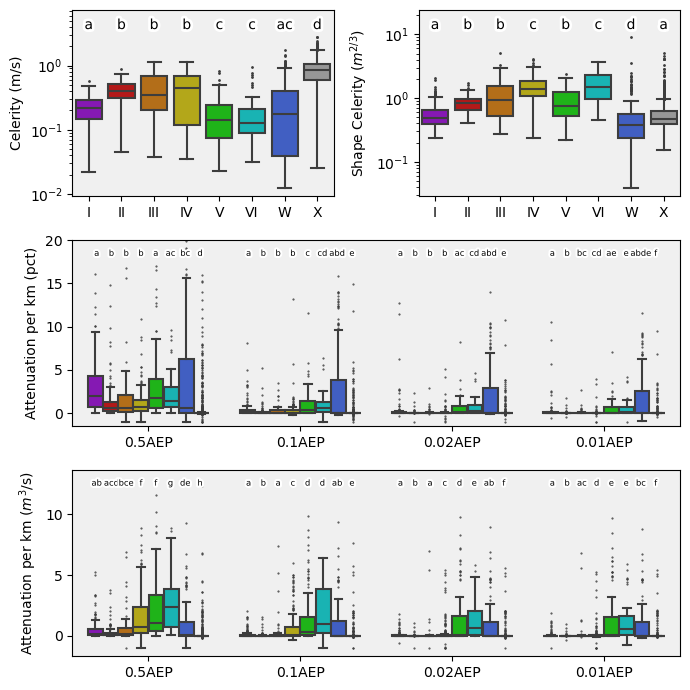

In [121]:
size = 7
aspect = (9 / 9)
w = size
h = size * aspect
showfliers = True
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(h, w))

# merge second and third row subplots to be big plots
axs[1, 0].remove()
axs[1, 1].remove()
axs[2, 0].remove()
axs[2, 1].remove()
gs = axs[1, 0].get_gridspec()
axbig1 = fig.add_subplot(gs[1, :])
gs = axs[2, 0].get_gridspec()
axbig2 = fig.add_subplot(gs[2, :])

# Panel 1:  cluster vs celerity
significance_scores = cel_groups
sns.boxplot(x='cluster', y='Celerity (m/s)', data=results, ax=axs[0, 0], palette=colors, order=order, flierprops={"marker": "o", 'markersize': 1}, showfliers=showfliers)
axs[0, 0].set_yscale('log')
axs[0, 0].set_ylim(axs[0, 0].get_ylim()[0], axs[0, 0].get_ylim()[1] * 2)
y = axs[0, 0].get_ylim()[1] * 0.75
for ind, label in enumerate(significance_scores):
    axs[0, 0].text(ind, y, label, ha='center', va='top', color='k', fontsize=10, zorder=100, path_effects=[pe.withStroke(linewidth=4, foreground="white")])
axs[0, 0].set_facecolor(background_color)
axs[0, 0].set_xlabel(None)


# Panel 2:  cluster vs shape celerity
significance_scores = shape_groups
sns.boxplot(x='cluster', y='Shape Celerity (m^(2/3))', data=results, ax=axs[0, 1], palette=colors, order=order, flierprops={"marker": "o", 'markersize': 1}, showfliers=showfliers)
axs[0, 1].set_yscale('log')
axs[0, 1].set_ylim(axs[0, 1].get_ylim()[0], axs[0, 1].get_ylim()[1] * 2)
y = axs[0, 1].get_ylim()[1] * 0.75
for ind, label in enumerate(significance_scores):
    axs[0, 1].text(ind, y, label, ha='center', va='top', color='k', fontsize=10, zorder=100, path_effects=[pe.withStroke(linewidth=4, foreground="white")])
axs[0, 1].set_ylabel(r'Shape Celerity $({m}^{2/3})$')
axs[0, 1].set_facecolor(background_color)
axs[0, 1].set_xlabel(None)


# Panel 3:  event vs attenuation cms
sns.boxplot(x='ri', y='Attenuation per km (pct)', data=pct_melted, ax=axbig1, hue='cluster', palette=c_dict, order=mag_order, hue_order=order, flierprops={"marker": "o", 'markersize': 0.5}, showfliers=showfliers)
# axbig1.set_ylim(axbig1.get_ylim()[0], axbig1.get_ylim()[1] * 1.1)
axbig1.set_ylim(-1.5, 20)
y = axbig1.get_ylim()[1] * 0.95
significance_scores = pct_groups.values()
width = (axbig1.get_xlim()[1] / 4) / 9
for ind, label in enumerate(significance_scores):
    for i2, l in enumerate(label):
        x = ind + (i2 - 3.5) * width
        axbig1.text(x, y, l, ha='center', va='top', color='k', fontsize=6, zorder=100, path_effects=[pe.withStroke(linewidth=3, foreground="white")])
axbig1.get_legend().remove()
axbig1.set_xlabel(None)
axbig1.set_facecolor(background_color)


# Panel 4:  event vs attenuation percent
sns.boxplot(x='ri', y='Attenuation per km (cms)', data=cms_melted, ax=axbig2, hue='cluster', palette=c_dict, order=mag_order, hue_order=order, flierprops={"marker": "o", 'markersize': 0.5}, showfliers=showfliers)
axbig2.set_ylim(axbig2.get_ylim()[0], axbig2.get_ylim()[1] * 1.05)
y = axbig2.get_ylim()[1] * 0.95
significance_scores = cms_groups.values()
width = (axbig2.get_xlim()[1] / 4) / 9
for ind, label in enumerate(significance_scores):
    for i2, l in enumerate(label):
        x = ind + (i2 - 3.5) * width
        axbig2.text(x, y, l, ha='center', va='top', color='k', fontsize=6, zorder=100, path_effects=[pe.withStroke(linewidth=3, foreground="white")])
axbig2.get_legend().remove()
axbig2.set_xlabel(None)
axbig2.set_ylabel(r'Attenuation per km (${m}^{3}$/s)')
axbig2.set_facecolor(background_color)


fig.tight_layout()
plt.show()


In [122]:
# Print number of percent attenuation per kilometer values above 20% for each magnitude
for ri in pct_melted['ri'].unique():
    subset = pct_melted[pct_melted['ri'] == ri]
    print(ri, len(subset[subset['Attenuation per km (pct)'] > 20]))

0.5AEP 27
0.1AEP 4
0.02AEP 0
0.01AEP 0


In [123]:
out_path = os.path.join(run_dict['analysis_directory'], 'clustering', 'final', 'Figure_8.png')
fig.savefig(out_path, dpi=400)

out_path = os.path.join(run_dict['analysis_directory'], 'clustering', 'final', 'Figure_8.pdf')
fig.savefig(out_path, dpi=400)